In [309]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as C

# Primer propelente

# Hanab ku propelente

In [310]:
P0=1000 #psi
Pe=14.69 #psi=presion atmosferica
k=1.136231 #1.139544
M=.03686465 # kg/mol
To=1855.11 #1940.74 #K
theta= np.pi/2
mp=0.350 # peso del propelente en kg

In [311]:
#march
def match(Pe, P0, k):
    c=(k-1)/k
    return np.sqrt(2/(k-1)*(1-(Pe/P0)**c))

def RatArea(M1, M2, k):
    a=(k+1)/(2*(k-1))
    b=(k-1)/2
    return M2/M1*(((1+b*M1**2)/(1+b*M2**2))**a)

def Cf(Pe, P0, k):
    a=(k+1)/(k-1)
    return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k)))

def thrust(Cf,At,P0):
    return At*P0*Cf*6894.757*10**(-6)

def Isp(k, Pe, Po, To, M):
    R=C.R
    a=(k-1)/k
    Isp=(1/C.g)*np.sqrt(((2*To*(R/(M*a))))*(1-(Pe/Po)**a))
    return Isp

def diametro(A):
    return np.sqrt(4*A/C.pi)

def altura(m, mp, F, Isp, angulo):
    #ax=F/m*np.cos(angulo)
    ay=(F/m)*np.sin(angulo)-C.g
    t1=(Isp)*mp*C.g/F

    # Fase 1
    h1=1/2*ay*t1**2
    V_y1=ay*t1
    # Fase 2
    t2=V_y1/C.g

    h=(ay*t1**2)*(1+ay/C.g)
    return h

def masa_propelente(F, Isp, m, h,angulo):
    ay=(F/m)*np.sin(angulo)-C.g
    mp=(F/Isp)*np.sqrt(2*h/(C.g*ay)*(1/(C.g+ay)))
    return mp

In [312]:
3/2*2

3.0

In [313]:
m=50 #kg
Mc=0.3
Mt=1
Me=match(Pe,P0,k)
Dc=39.6 #mm
Ac=C.pi*(Dc/2)**2 #mm**2
Dc=diametro(Ac) ## mm

In [314]:
AtAc=RatArea(Mt,Mc,k)
At=Ac*AtAc
AeAt=RatArea(Me,Mt,k)
Ae=At*AeAt
AeAc=RatArea(Me,Mc,k)
Ae2=Ac*AeAc
De2=diametro(Ae2)
De=diametro(Ae)
Dt=diametro(At)
Cf=Cf(Pe,P0,k)
F=thrust(Cf,At,P0)
Isp=Isp(k,Pe,P0,To,M) #159 s

In [315]:
print(De2/2,De/2,Dt/2,Dc/2,Mc,Me,Mt,Cf,F) # Dt,Dc=mm match,Cf=sin dimendiones, F=N

25.278538494244625 25.27853849424462 13.709153442363254 19.8 0.3 2.41455932750138 1 1.6365306719233723 6662.147767373336


In [316]:
print(AeAc,Ac,AeAt,At, Ae) # En mm2

1.6299472207045387 1231.6299839133426 3.400029205160078 590.4337133837686 2007.4918692159279


## Altitud

In [317]:
a=F/m-C.g
#t=Isp*mp*C.g/F
h=altura(m+mp ,mp, F, Isp, np.pi/2)
mp1=masa_propelente(F, Isp, m, 3000, np.pi/2)

In [318]:
print(Isp,F, Cf, h, mp1)

169.76470007795893 6662.147767373336 1.6365306719233723 12.644732950721892 7.569001173650444


In [319]:
print(F, Isp, m, 3000, np.pi/2)

6662.147767373336 169.76470007795893 50 3000 1.5707963267948966


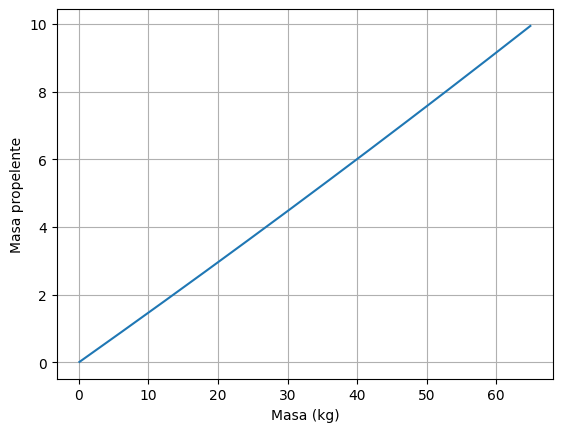

In [345]:
x=np.arange(.1, 65 , 0.1)
y=masa_propelente(F, Isp, x, 3000, np.pi/2)

plt.plot(x,y)
plt.xlabel('Masa (kg)')
plt.ylabel('Masa propelente')
plt.grid()
plt.show()

In [346]:
print(y[20]/x[20],y[40]/x[40],y[60]/x[60] )

0.1459285206658578 0.1461444712371055 0.14636138337020602


In [347]:
x[40]

4.1

Para poder obtener la masa total incluyendo el propelente se puede se puede resolver con una serie geometrica de la forma
$$
M=\Sigma_{n=0}^\infty (MR)^n=\frac{1}{1-MR}
$$
Para poder obtener un MR razonable se necesita hacer un promedio de la funcion de mp/m=MR de la forma
$$
 MR=\langle \frac{mp}{m} \rangle=\frac{1}{I_{sp}}\sqrt{\frac{2hF}{gsen\theta}} \frac{1}{b-a}\int_a^b\frac{dm}{\sqrt{Fsen\theta-mg}} 
$$


In [354]:
# Integral de mp/m
from scipy import integrate
h=3000 # metros
a, b = 0, 70
c=(Isp)**-1*np.sqrt(2*h*F/(np.sin(theta)*C.g))
K= lambda m: c*(1/np.sqrt(F*np.sin(theta)-C.g*m))   

MR=1/(b-a)*(integrate.quadrature(K, a, b)[0])

M=m*(1/(1-MR))

In [355]:
M

58.80020906991275